# Initial Set Up

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import sklearn
import _pickle as cPickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve

# Preliminary Visualisation and Processing

In [71]:
messages = [line.rstrip() for line in open('./Data/Raw.csv')]
print(len(messages))
for message_no, message in enumerate(messages[1:11]):
    print(message_no, message)

5729
0 "Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : y

## Splitting the `text` into Subject & Content

In [72]:
source = open('Data/Raw.csv', 'r')
reader = csv.reader(source)
next(reader)
i = 0
subjects = []
contents = []
labels = []

for line in reader:
    i += 1
    text = line[0]
    label = line[1]
    if label == '0':
        label = "spam"
    else: 
        label = 'ham'
        
    try:
        subject = text[text.index("Subject") + len("Subject:")
                    : text.index("  ")].strip()
        content = text[text.index("  ") :].strip()
    except ValueError:
        subject = text[text.index("Subject") + len("Subject:")
                    :]
        content = ""
    subjects += [subject]
    contents += [content]
    labels.append(label)

df = pd.DataFrame({'subject': subjects,
                   'content': contents,
                   'label': labels})
df.to_csv('Data/Pre-processed.csv', index=False)

## Separating the Data into Training, Testing and Validation

In [73]:
def split_ttv(data, test_ratio, val_ratio):
    shuffled_indices = np.random\
                        .default_rng(seed=42)\
                        .permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    val_set_size = int(len(data) * val_ratio)
    test_indices = shuffled_indices[:test_set_size]
    val_indices = shuffled_indices[test_set_size:
        test_set_size + val_set_size]
    train_indices = shuffled_indices[test_set_size + val_set_size:]
    return (data.iloc[train_indices],
            data.iloc[test_indices],
            data.iloc[val_indices])

In [74]:
df = pd.read_csv('Data/Pre-processed.csv',
                 header=0)
train, test, validation = split_ttv(df, 0.2, 0.1)
train.to_csv('Data/train.csv', index=False)
test.to_csv('Data/test.csv', index=False)
validation.to_csv('Data/validation.csv', index=False)

## Visualising the New Data

In [75]:
messages = pd.read_csv('Data/train.csv',
                       header=0)

<Axes: ylabel='Frequency'>

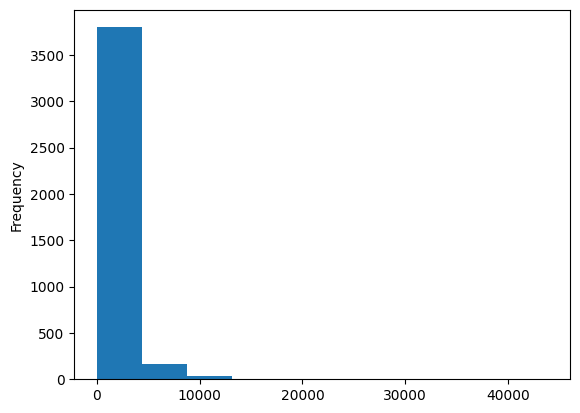

In [76]:
messages['content length'] = messages['content'].map(lambda text: len(str(text)))
messages['content length'].plot(bins=10, kind='hist')

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

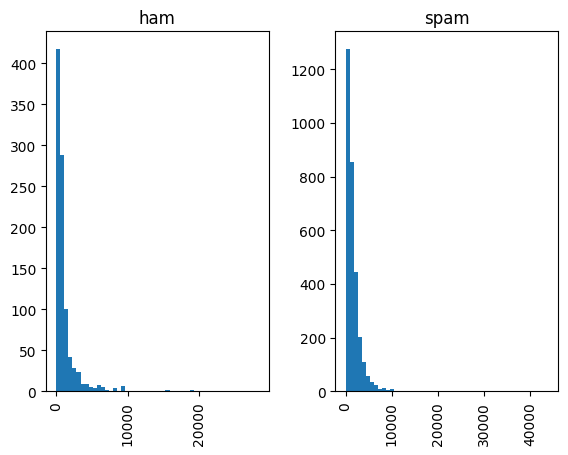

In [77]:
messages['content length'].describe()
messages.hist(column='content length', by='label', bins=50)